# Import packages

In [1]:
# パッケージのインポート
import numpy as np
import pandas as pd
import gc
import json
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tqdm import tqdm_notebook as tqdm
from typing import Dict, List
from collections import Counter
from numba import jit 

import hyperopt
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

from IPython.display import display # Allows the use of display() for DataFrames
from IPython.core.display import display, HTML

from pylab import rcParams
import matplotlib.font_manager as fm
import warnings

warnings.filterwarnings("ignore")
display(HTML("<style>.container { width:80% !important; }</style>")) # 表示画面サイズ変更

# ①日本語を表示するためのフォントの指定
# print([f.name for f in fm.fontManager.ttflist])
# ②日本語フォントがない場合
# print(matplotlib.matplotlib_fname())
# ③上記で表示されたフォルダのパスの途中(.../mpl-data/fonts/ttf)に.ttfを格納し、下記を実行
# print(matplotlib.get_cachedir())
# ④上記フォルダ内の"fontlist~.json"を削除して下記でリビルド
# matplotlib.font_manager._rebuild()
# ⑤フォントの一覧に.ttfで追加したフォントが表示されるはず

In [2]:
# matplotlibの設定
rcParams["figure.figsize"] = (14, 8)
sns.set(style="whitegrid", font=["IPAPGothic"], font_scale=1.5)

# Read data

このデータセットでは、PBS KIDS Measure Up！のゲーム分析が提供されます。<br>
このアプリでは、子供たちがマップをナビゲートし、アクティビティ、ビデオクリップ、ゲーム、または評価などのさまざまなレベルを完了します。<br>
各評価は、測定関連スキルの特定のセットの子供の理解度をテストするように設計されています。<br>
5つの評価があります：バードメジャラー、カートバランサー、コールドロンフィラー、チェストソーター、マッシュルームソーター。<Br>
<br>
競争の目的は、ゲームプレイデータを使用して、特定の評価に合格するために子供が何回試行するかを予測することです（不正解は試行としてカウントされます）。<br>
各アプリケーションのインストールは、installation_idで表されます。これは通常、1人の子に対応しますが、<br>
共有デバイスなどの問題からのノイズを期待する必要があります。トレーニングセットでは、ゲームプレイデータの完全な履歴が提供されます。<br>
テストセットでは、試行回数を予測する必要があるランダムに選択された単一の評価の開始イベント後に履歴を切り捨てました。<br>
テストセット内のすべてのinstallation_idが少なくとも1つの評価で試行されたのに対して、<br>
トレーニングセットには評価を受けなかった多数のinstallation_idが含まれていることに注意してください。<Br>
<br>
このコンペティションの結果は、4つのグループにグループ化されます（データ内の正確度グループとラベル付けされています）：<br>
<br>
3：評価は最初の試行で解決されました<br>
2：2回目の試行で評価が解決された<br>
1：3回以上の試行の後に評価が解決された<br>
0：評価は解決されなかった<br>
ファイルtrain_labels.csvは、これらのグループがトレーニングセットの評価でどのように計算されるかを示すために提供されています。<br>
評価の試行は、event_code 4110を使用するBird Measurerを除くすべての評価のevent_code 4100でキャプチャされます。<br>
試行が正しければ、「correct」：trueが含まれます。<br>
<br>
**＜和田追記＞<br>
train_labels.csvにはcorrect回数とincorrect回数がある。この数によって、目的変数が定まる。そして、correct、incorrectが決まるタイミングがevent_code4100（Bird Measurerの場合は4110）ということ。**
<br>

**train.csv&test.csv**<br>
これらは、ゲームプレイイベントを含むメインデータファイルです。<br>
* event_id-イベントタイプに対してランダムに生成された一意の識別子。 specsテーブルのevent_id列にマップします。<br>
  ＜和田追記＞異なるidなのに中身が同じ、1カンマ違いあり。まとめるといいかも<br>
  　　　　　　"type"×各"event_code"分存在する<br>
* game_session-単一のゲームまたはビデオプレイセッション内でランダムに生成された、イベントをグループ化する一意の識別子。<br>
  ＜和田追記＞game_sessionは、あるタイプのイベントが始まってから終わるまでの識別子。Clipはそれぞれに割り当てられる<br>
* timestamp-クライアント生成の日時
* event_data-イベントパラメーターを含む半構造化JSON形式の文字列。デフォルトのフィールドは、event_count、event_code、およびgame_timeです。それ以外の場合、フィールドはイベントタイプによって決定されます。
* nstallation_id-単一のインストール済みアプリケーションインスタンス内でランダムに生成された一意の識別子グループ化ゲームセッション。
* event_count-ゲームセッション内のイベントの増分カウンター（1でオフセット）。 event_dataから抽出。
* event_code-イベント「クラス」の識別子。ゲームごとに一意ですが、ゲーム間で重複する場合があります。例えば。イベントコード「2000」は、すべてのゲームの「ゲーム開始」イベントを常に識別します。 event_dataから抽出。
* game_time-ゲームセッションの開始からのミリ秒単位の時間。 event_dataから抽出。
* title-ゲームまたはビデオのタイトル。
* type-ゲームまたはビデオのメディアタイプ。可能な値は、「ゲーム」、「評価」、「アクティビティ」、「クリップ」です。
* world-ゲームまたはビデオが属するアプリケーションのセクション。メディアの教育カリキュラムの目標を特定するのに役立ちます。指定可能な値は、「NONE」（アプリの開始画面）、「TREETOPCITY」（長さ/高さ）、「MAGMAPEAK」（容量/変位）、「CRYSTALCAVES」（重量）です。
<br>

**specs.csv**<br>
このファイルは、さまざまなイベントタイプの仕様を提供します。<br>
* event_id-イベントタイプのグローバルな一意の識別子。イベントテーブルのevent_id列に結合します。
* info-イベントの説明。
* args-イベント引数のJSON形式の文字列。各引数には次が含まれます。
* name-引数名。
* type-引数のタイプ（文字列、整数、数値、オブジェクト、配列）。
* info-引数の説明。

**train_labels.csv**<br>
このファイルは、トレーニングセットの評価のグラウンドトゥルースを計算する方法を示しています。<br>

In [4]:
data_dir = None
if _dh == ["/kaggle/working"]:
    data_dir = "/kaggle/input/data-science-bowl-2019/"
else:
    data_dir = "data/"

In [5]:
train_df = pd.read_csv(data_dir + "train.csv")
train_df

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK
...,...,...,...,...,...,...,...,...,...,...,...
11341037,ab3136ba,c09b94eebfdf50a6,2019-10-10T15:11:15.584Z,"{""description"":""Tap another dinosaur."",""identi...",fffc0583,66,3110,118615,Dino Dive,Game,MAGMAPEAK
11341038,27253bdc,6ad8ab25003ef1b0,2019-10-10T15:12:17.364Z,"{""event_code"": 2000, ""event_count"": 1}",fffc0583,1,2000,0,Crystal Caves - Level 2,Clip,CRYSTALCAVES
11341039,27253bdc,71904dca23b982c6,2019-10-10T15:13:04.713Z,"{""event_code"": 2000, ""event_count"": 1}",fffc0583,1,2000,0,Crystal Caves - Level 3,Clip,CRYSTALCAVES
11341040,27253bdc,2267b18f069e875a,2019-10-10T15:13:54.545Z,"{""event_code"": 2000, ""event_count"": 1}",fffc0583,1,2000,0,Crystal Caves - Level 3,Clip,CRYSTALCAVES


In [6]:
test_df = pd.read_csv(data_dir + "test.csv")
test_df

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,0ea9ecc81a565215,2019-09-10T16:50:24.910Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,c1ea43d8b8261d27,2019-09-10T16:50:55.503Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,27253bdc,7ed86c6b72e725e2,2019-09-10T16:51:51.805Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK
3,27253bdc,7e516ace50e7fe67,2019-09-10T16:53:12.825Z,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Crystal Caves - Level 1,Clip,CRYSTALCAVES
4,7d093bf9,a022c3f60ba547e7,2019-09-10T16:54:12.115Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",00abaee7,1,2000,0,Chow Time,Game,CRYSTALCAVES
...,...,...,...,...,...,...,...,...,...,...,...
1156409,c74f40cd,46ff9d3ad2be09f2,2019-09-28T21:20:40.918Z,"{""description"":""Alright! This one is the littl...",ffe774cc,39,3121,32030,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156410,6c930e6e,46ff9d3ad2be09f2,2019-09-28T21:20:41.493Z,"{""duration"":20008,""misses"":0,""event_count"":40,...",ffe774cc,40,2030,32584,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156411,a5be6304,46ff9d3ad2be09f2,2019-09-28T21:20:45.499Z,"{""session_duration"":36607,""exit_type"":""game_co...",ffe774cc,41,2010,36607,Mushroom Sorter (Assessment),Assessment,TREETOPCITY
1156412,27253bdc,96d7dc31e822cedc,2019-09-28T21:21:05.670Z,"{""event_code"": 2000, ""event_count"": 1}",ffe774cc,1,2000,0,Tree Top City - Level 3,Clip,TREETOPCITY


In [7]:
train_labels_df = pd.read_csv(data_dir + "train_labels.csv")
train_labels_df

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.000000,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.000000,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.500000,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.000000,3
...,...,...,...,...,...,...,...
17685,c996482b11d149dd,ffc90c32,Bird Measurer (Assessment),1,0,1.000000,3
17686,b05a02b52d5c1f4c,ffd2871d,Cauldron Filler (Assessment),1,0,1.000000,3
17687,5448d652309a6324,ffeb0b1b,Cauldron Filler (Assessment),1,2,0.333333,1
17688,a6885ab824fbc32c,ffeb0b1b,Mushroom Sorter (Assessment),0,1,0.000000,0


In [11]:
pd.merge(train_df, train_labels_df, on=["game_session", "installation_id"], how="inner")

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title_x,type,world,title_y,num_correct,num_incorrect,accuracy,accuracy_group
0,3bfd1a65,901acc108f55a5a1,2019-08-06T05:22:01.344Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,Mushroom Sorter (Assessment),1,0,1.000000,3
1,db02c830,901acc108f55a5a1,2019-08-06T05:22:01.400Z,"{""event_count"":2,""game_time"":37,""event_code"":2...",0006a69f,2,2025,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,Mushroom Sorter (Assessment),1,0,1.000000,3
2,a1e4395d,901acc108f55a5a1,2019-08-06T05:22:01.403Z,"{""description"":""Pull three mushrooms out of th...",0006a69f,3,3010,37,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,Mushroom Sorter (Assessment),1,0,1.000000,3
3,a52b92d5,901acc108f55a5a1,2019-08-06T05:22:05.242Z,"{""description"":""Pull three mushrooms out of th...",0006a69f,4,3110,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,Mushroom Sorter (Assessment),1,0,1.000000,3
4,a1e4395d,901acc108f55a5a1,2019-08-06T05:22:05.244Z,"{""description"":""To pick a mushroom, pull it ou...",0006a69f,5,3010,3901,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,Mushroom Sorter (Assessment),1,0,1.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865442,28520915,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""misses"":1,""prompt"":""holds least"",""mode"":""sel...",ffeb0b1b,58,2030,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1,2,0.333333,1
865443,91561152,5448d652309a6324,2019-09-22T02:07:27.562Z,"{""bucket"":1,""buckets_placed"":[3,1,2],""target_b...",ffeb0b1b,57,4025,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1,2,0.333333,1
865444,d3268efa,5448d652309a6324,2019-09-22T02:07:27.566Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,59,3021,67094,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1,2,0.333333,1
865445,b5053438,5448d652309a6324,2019-09-22T02:07:28.311Z,"{""description"":""Awesome."",""identifier"":""Dot_Aw...",ffeb0b1b,60,3121,67847,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,Cauldron Filler (Assessment),1,2,0.333333,1


In [8]:
sample_submission = pd.read_csv(data_dir + "sample_submission.csv")
sample_submission

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
...,...,...
995,fee254cf,3
996,ff57e602,3
997,ffc73fb2,3
998,ffe00ca8,3


In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # TODO: categoryとdatetimeの分岐
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
# TODO:これをやるとなぜかメモリ使用量が増える
# train_df = reduce_mem_usage(train_df)
# test_df = reduce_mem_usage(test_df)
# train_labels_df = reduce_mem_usage(train_labels_df)
# specs_df = reduce_mem_usage(specs_df)

In [11]:
gc.collect()

50

# Deeper FE

In [12]:
def add_feature(df):
    # convert text into datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    df["title_event_code"] = list(map(lambda x, y: str(x) + "_" + str(y), df["title"], df["event_code"]))
    #df["type_world"] = list(map(lambda x, y: str(x) + "_" + str(y), df["type"], df["world"]))
    df["event_code_bins"] = [str(event_code//1000) + "xxx" for event_code in df["event_code"]]
    df["title_event_code_bins"] = list(map(lambda x, y: str(x) + "_" + str(y), df["title"], df["event_code_bins"]))
    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    
    return df

In [13]:
clip_time = {"Welcome to Lost Lagoon!": 19,"Tree Top City - Level 1": 17,"Ordering Spheres": 61, "Costume Box": 61,
            "12 Monkeys": 109,"Tree Top City - Level 2": 25, "Pirate\'s Tale": 80, "Treasure Map": 156,"Tree Top City - Level 3": 26,
            "Rulers": 126, "Magma Peak - Level 1": 20, "Slop Problem": 60, "Magma Peak - Level 2": 22, "Crystal Caves - Level 1": 18,
            "Balancing Act": 72, "Lifting Heavy Things": 118,"Crystal Caves - Level 2": 24, "Honey Cake": 142, "Crystal Caves - Level 3": 19,
            "Heavy, Heavier, Heaviest": 61}

In [14]:
def extract_event_data(sess):
    cnt_miss = 0
    max_level = 0
    max_round = 0
    for i in range(len(sess)):
        event_str = sess["event_data"].iloc[i]
        
        if "\"misses\"" in event_str:
            # missesはlevelごとに引き継がれないので、和でよい
            cnt_miss += json.loads(event_str)["misses"]
        
        if "\"level\"" in event_str:
            level = json.loads(event_str)["level"]
            if level > max_level:
                max_level = level
        
        if "\"round\"" in event_str:
            rounds = json.loads(event_str)["round"]
            if rounds > max_round:
                max_round = rounds            
        
    return cnt_miss, max_level, max_round

In [15]:
def encode_title(train, test, train_labels):    
    # make a list with all the uniques from the train and test set
    list_of_user_activities = sorted(list(set(train["title"].unique()).union(set(test["title"].unique()))))
    list_of_event_code = sorted(list(set(train["event_code"].unique()).union(set(test["event_code"].unique()))))
    list_of_event_code_bins = sorted(list(set(train["event_code_bins"].unique()).union(set(test["event_code_bins"].unique()))))
    list_of_event_id = sorted(list(set(train["event_id"].unique()).union(set(test["event_id"].unique()))))
    list_of_worlds = sorted(list(set(train["world"].unique()).union(set(test["world"].unique()))))
    #list_of_assess_titles = sorted(list(set(train[train["type"] == "Assessment"]["title"].value_counts().index) \
    #                                    .union(set(test[test["type"] == "Assessment"]["title"].value_counts().index))))
    list_of_title_event_code = sorted(list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique())))
    list_of_title_event_code_bins = sorted(list(set(train["title_event_code_bins"].unique()).union(test["title_event_code_bins"].unique())))
    #list_of_type_world = sorted(list(set(train["type_world"].unique()).union(test["type_world"].unique())))
    
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = {'CRYSTALCAVES': 0, 'MAGMAPEAK': 1, 'TREETOPCITY': 2, 'NONE': 3} #activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    
    print(activities_map)
    print(activities_labels)
    print(activities_world)
    
    # replace the text titles with the number titles from the dict
    train["title"] = train["title"].map(activities_map)
    test["title"] = test["title"].map(activities_map)
    train["world"] = train["world"].map(activities_world)
    test["world"] = test["world"].map(activities_world)
    train_labels["title"] = train_labels["title"].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype("int")))
    # then, it set one element, the "Bird Measurer (Assessment)" as 4110, 10 more than the rest
    win_code[activities_map["Bird Measurer (Assessment)"]] = 4110
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, list_of_event_code_bins, activities_labels, list_of_event_id, list_of_title_event_code, list_of_title_event_code_bins
    #return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, list_of_event_code_bins, activities_labels, list_of_assess_titles, list_of_event_id, list_of_title_event_code, list_of_title_event_code_bins, list_of_type_world

In [16]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    """
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    """
    all_assessments = []
    
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    user_activities_count = {"Clip": 0, "Activity": 0, "Assessment": 0, "Game": 0}
    assessment_durations = []
    clip_durations = []
    activity_durations = []
    game_durations = []
    last_activity = 0
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    accumulated_misses = 0
    accumulated_rounds = 0
    accumulated_levels = 0
    game_counter = 0
    assessment_counter = 0
    sessions_count = 0
    
    # new features: time spent in each activity
    #last_accuracy_title = {"acc_" + title: -1 for title in list_of_assess_titles}
    event_code_count = {eve: 0 for eve in list_of_event_code}
    event_code_bins_count = {eve: 0 for eve in list_of_event_code_bins}
    event_id_count = {eve: 0 for eve in list_of_event_id}
    title_count = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count = {eve: 0 for eve in list_of_title_event_code}
    title_event_code_bins_count = {eve: 0 for eve in list_of_title_event_code_bins}
    #type_world_count = {eve: 0 for eve in list_of_type_world}
        
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby("game_session", sort=False):
            
        # get some sessions information
        session_type = session["type"].iloc[0]
        session_title = session["title"].iloc[0]
        session_title_text = activities_labels[session_title]
        
        #print(session_type, session["world"].iloc[0], session_title)
        
        if session_type == "Clip":
            clip_durations.append((clip_time[activities_labels[session_title]]))

        if session_type == "Activity":
            activity_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            
        if session_type == "Game":
            game_durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            cnt_miss, max_level, max_round = extract_event_data(session)
            accumulated_misses += cnt_miss
            accumulated_rounds += max_round
            accumulated_levels += max_level
            game_counter += 1
                                   
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == "Assessment") & (test_set or len(session) > 1):            

            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f"event_code == {win_code[session_title]}")
            
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts["event_data"].str.contains("true").sum()
            false_attempts = all_attempts["event_data"].str.contains("false").sum()
            
            # copy a dict to use as feature template, it"s initialized with some itens: 
            features = user_activities_count.copy()
            #features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_code_bins_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(title_event_code_bins_count.copy())
            #features.update(type_world_count.copy())
  
            # count non-zeros features
            variety_features = [("var_event_code", event_code_count),
                                ("var_event_id", event_id_count),
                                ("var_title", title_count),
                                ("var_title_event_code", title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)       
                
            # add time related features
            features["hour"] = session["hour"].iloc[-1]
            features["weekday"] = session["weekday"].iloc[-1]
            features["dayofweek"] = session["dayofweek"].iloc[-1]
            
            # get installation_id for aggregated features
            features["installation_id"] = session["installation_id"].iloc[-1]
            features["installation_session_count"] = sessions_count
            
            # add title as feature, remembering that title represents the name of the game
            features["session_title"] = session["title"].iloc[0]
            
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features["accumulated_correct_attempts"] = accumulated_correct_attempts
            features["accumulated_uncorrect_attempts"] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            
            # the time spent in the app so far
            if assessment_durations == []:
                features["assessment_duration_mean"] = 0
                features["assessment_duration_std"] = 0
            else:
                features["assessment_duration_mean"] = np.mean(assessment_durations)
                features["assessment_duration_std"] = np.std(assessment_durations)
                
            if clip_durations == []:
                features["clip_duration_mean"] = 0
                features["clip_duration_std"] = 0
            else:
                features["clip_duration_mean"] = np.mean(clip_durations)
                features["clip_duration_std"] = np.std(clip_durations)
                
            if activity_durations == []:
                features["activity_duration_mean"] = 0
                features["activity_duration_std"] = 0
            else:
                features["activity_duration_mean"] = np.mean(activity_durations)
                features["activity_duration_std"] = np.std(activity_durations)
                
            if game_durations == []:
                features["game_duration_mean"] = 0
                features["game_duration_std"] = 0
            else:
                features["game_duration_mean"] = np.mean(game_durations)
                features["game_duration_std"] = np.std(game_durations)
                
            assessment_durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds)
            
            # the accurace is the all time wins divided by the all time attempts
            features["accumulated_accuracy"] = accumulated_accuracy/assessment_counter if assessment_counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            #last_accuracy_title["acc_" + session_title_text] = accuracy
            
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features["accuracy_group"] = 0
            elif accuracy == 1:
                features["accuracy_group"] = 3
            elif accuracy == 0.5:
                features["accuracy_group"] = 2
            else:
                features["accuracy_group"] = 1
            features.update(accuracy_groups)
            accuracy_groups[features["accuracy_group"]] += 1
            
            # mean of the all accuracy groups of this player
            features["accumulated_accuracy_group"] = accumulated_accuracy_group/assessment_counter if assessment_counter > 0 else 0
            accumulated_accuracy_group += features["accuracy_group"]
            
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features["accumulated_actions"] = accumulated_actions
            
            # wada"s adding features
            features["accumulated_game_rounds"] = accumulated_rounds/game_counter if game_counter > 0 else 0
            features["accumulated_game_levels"] = accumulated_levels/game_counter if game_counter > 0 else 0
            features["accumulated_game_misses"] = accumulated_misses/game_counter if game_counter > 0 else 0
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it"s a test set, all sessions belong to the final dataset
            # if it"s a train, needs to be passed throught this clausule: session.query(f"event_code == {win_code[session_title]}")
            # that means, must exist an event_code 4100 or 4110. 追記：Assessmentの中でも4100, 4110がないものもあるため
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            assessment_counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
            num_of_session_count = Counter(session[col])
            for k in num_of_session_count.keys():
                x = k
                if col == "title":
                    x = activities_labels[k]
                counter[x] += num_of_session_count[k]
            return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_code_bins_count = update_counters(event_code_bins_count, "event_code_bins")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, "title")
        title_event_code_count = update_counters(title_event_code_count, "title_event_code")
        title_event_code_bins_count = update_counters(title_event_code_bins_count, "title_event_code_bins")
        #type_world_count = update_counters(type_world_count, "type_world")
        
        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activity = session_type
            
        sessions_count += 1
    
    # if it"t the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    else:
        return all_assessments
    
    # imitate the split between train and test
#     if test_set:
#         return all_assessments[-1]
#     else:
#         random.seed(0)
#         return random.sample(all_assessments, (2 if len(all_assessments) >= 2 else len(all_assessments))) # 5つをランダム選択　5つ未満ならすべて

In [17]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby("installation_id", sort=False)), total=17000):
        compiled_train += get_data(user_sample, test_set=False)
    for ins_id, user_sample in tqdm(test.groupby("installation_id", sort=False), total=1000):
        compiled_test.append(get_data(user_sample, test_set=True))
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    return reduce_train, reduce_test

In [18]:
# adding some features
train_df = add_feature(train_df)
test_df = add_feature(test_df)

In [19]:
# get usefull dict with maping encode
train_df, test_df, train_labels_df, win_code, list_of_user_activities, list_of_event_code, list_of_event_code_bins, activities_labels, list_of_event_id, list_of_title_event_code, list_of_title_event_code_bins = encode_title(train_df, test_df, train_labels_df)
#train_df, test_df, train_labels_df, win_code, list_of_user_activities, list_of_event_code, list_of_event_code_bins, activities_labels, list_of_assess_titles, list_of_event_id, list_of_title_event_code, list_of_title_event_code_bins, list_of_type_world = encode_title(train_df, test_df, train_labels_df)

{'12 Monkeys': 0, 'Air Show': 1, 'All Star Sorting': 2, 'Balancing Act': 3, 'Bird Measurer (Assessment)': 4, 'Bottle Filler (Activity)': 5, 'Bubble Bath': 6, 'Bug Measurer (Activity)': 7, 'Cart Balancer (Assessment)': 8, 'Cauldron Filler (Assessment)': 9, 'Chest Sorter (Assessment)': 10, 'Chicken Balancer (Activity)': 11, 'Chow Time': 12, 'Costume Box': 13, 'Crystal Caves - Level 1': 14, 'Crystal Caves - Level 2': 15, 'Crystal Caves - Level 3': 16, 'Crystals Rule': 17, 'Dino Dive': 18, 'Dino Drink': 19, 'Egg Dropper (Activity)': 20, 'Fireworks (Activity)': 21, 'Flower Waterer (Activity)': 22, 'Happy Camel': 23, 'Heavy, Heavier, Heaviest': 24, 'Honey Cake': 25, 'Leaf Leader': 26, 'Lifting Heavy Things': 27, 'Magma Peak - Level 1': 28, 'Magma Peak - Level 2': 29, 'Mushroom Sorter (Assessment)': 30, 'Ordering Spheres': 31, 'Pan Balance': 32, "Pirate's Tale": 33, 'Rulers': 34, 'Sandcastle Builder (Activity)': 35, 'Scrub-A-Dub': 36, 'Slop Problem': 37, 'Treasure Map': 38, 'Tree Top City - L

In [20]:
# tranform function to get the train and test set
train_df, test_df = get_train_and_test(train_df, test_df)

In [21]:
train_df

,Clip,Activity,Assessment,Game,2000,2010,2020,2025,2030,2035,...,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions,accumulated_game_rounds,accumulated_game_levels,accumulated_game_misses
0,6,3,0,2,18,0,20,4,18,0,...,3,0,0,0,0,0.0,647,5.000000,1.500000,3.750000
1,8,4,1,4,25,1,26,5,22,1,...,0,0,0,0,1,3.0,1143,4.166667,1.000000,2.666667
2,8,4,2,4,26,1,27,5,22,1,...,3,1,0,0,1,1.5,1230,4.166667,1.000000,2.666667
3,15,9,3,7,47,2,52,9,43,5,...,2,2,0,0,2,1.5,2159,4.000000,1.000000,1.900000
4,17,10,3,9,56,3,64,10,53,6,...,3,2,0,1,2,1.6,2586,3.923077,0.769231,1.615385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17685,13,7,4,10,49,4,62,5,55,3,...,3,0,1,0,4,2.6,1963,4.363636,0.363636,1.090909
17686,2,2,0,2,8,0,34,2,31,1,...,3,0,0,0,0,0.0,888,3.000000,0.000000,1.666667
17687,4,3,0,2,18,0,16,0,15,0,...,1,0,0,0,0,0.0,932,4.000000,0.000000,3.500000
17688,7,3,1,4,33,1,28,0,25,0,...,0,0,1,0,0,1.0,1358,4.333333,0.000000,4.000000


In [22]:
test_df

,Clip,Activity,Assessment,Game,2000,2010,2020,2025,2030,2035,...,accuracy_group,0,1,2,3,accumulated_accuracy_group,accumulated_actions,accumulated_game_rounds,accumulated_game_levels,accumulated_game_misses
0,5,3,1,3,25,1,11,1,7,0,...,0,0,0,0,1,3.00,867,3.000000,0.0,1.333333
1,16,11,5,11,57,4,85,2,80,2,...,0,1,1,2,1,1.60,2718,4.916667,0.5,0.750000
2,2,2,0,0,8,0,0,0,0,0,...,0,0,0,0,0,0.00,149,0.000000,0.0,0.000000
3,4,2,0,1,13,0,3,2,3,0,...,0,0,0,0,0,0.00,233,3.000000,0.0,4.000000
4,5,1,0,4,24,0,28,9,25,0,...,0,0,0,0,0,0.00,951,4.666667,0.0,4.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,0,2,1,8,2,8,2,6,1,...,0,1,0,0,2,2.00,211,4.000000,0.0,3.000000
996,5,2,1,2,16,1,7,0,7,0,...,0,0,0,0,1,3.00,302,3.000000,0.0,3.000000
997,7,2,4,0,38,3,6,1,5,1,...,0,1,1,0,2,1.75,525,0.000000,0.0,0.000000
998,3,2,1,1,18,0,6,0,2,0,...,0,1,1,1,0,1.00,258,1.000000,0.0,0.000000


In [23]:
# train_dfとtrain_labels_dfの目的変数のユニーク数は一致する（順番は異なるが）
display(train_df["accuracy_group"].value_counts())
display(train_labels_df["accuracy_group"].value_counts())

3    8845
0    4229
1    2411
2    2205
Name: accuracy_group, dtype: int64

3    8845
0    4229
1    2411
2    2205
Name: accuracy_group, dtype: int64

In [24]:
train_df.to_csv("train_case11.csv", index=False)
test_df.to_csv("test_case11.csv", index=False)

In [25]:
gc.collect()

1099

# CV strategy

* 5gkfするよりも全データで学習したほうがLBで精度が出る
* installation_idのユニーク数が多く、切り方に問題があるのでは
* aptosコンペの1st solutionでは、全データ学習しvalidationをLBとしている　要確認

In [26]:
train_df = pd.read_csv("train_case11.csv")
test_df = pd.read_csv("test_case11.csv")

In [27]:
# train_df.drop(train_df.columns[train_df.columns.str.contains("Assessment")], axis=1, inplace=True)
# test_df.drop(test_df.columns[test_df.columns.str.contains("Assessment")], axis=1, inplace=True)

In [28]:
train_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in train_df.columns]
test_df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in test_df.columns]

* 今回のタスクにおいて、学習データとテストデータにinstallation_idの被りがない<br>
 そのため、StratifiedKFoldのような学習と検証に同じinstallation_idが混ざるCVは適切でない<br>
 よって、GroupKFoldとするのが多分良い

# Feature selection

## missing

In [29]:
# Check if there are any NULL values in Train Data
print("Total Train Features with NaN Values = " + str(train_df.columns[train_df.isnull().sum() != 0].size))
if (train_df.columns[train_df.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(train_df.columns[train_df.isnull().sum() != 0])))
    train_df[train_df.columns[train_df.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Train Features with NaN Values = 0


In [30]:
# Check if there are any NULL values in Test Data
print("Total Test Features with NaN Values = " + str(test_df.columns[test_df.isnull().sum() != 0].size))
if (test_df.columns[test_df.isnull().sum() != 0].size):
    print("Features with NaN => {}".format(list(test_df.columns[test_df.isnull().sum() != 0])))
    test_df[test_df.columns[test_df.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False)

Total Test Features with NaN Values = 0


## low variance

In [31]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=.01)
selector.fit(train_df.drop(["installation_id", "accuracy_group"], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

cols_to_remove = train_df.drop(["installation_id", "accuracy_group"], axis=1).columns[f(selector.get_support())]

print("{} variables have too low variance.".format(len(cols_to_remove)))
print("These variables are {}".format(list(cols_to_remove)))

30 variables have too low variance.
These variables are ['003cd2ee', '01ca3a3c', '0ce40006', '119b5b02', '17ca3959', '1b54d27f', '29a42aea', '4074bac2', '5dc079d8', '6077cc36', '611485c5', 'a8cc6fec', 'ab4ec3a4', 'dcb1663e', 'e4d32835', 'Air_Show_4080', 'Bird_Measurer__Assessment__4080', 'Bottle_Filler__Activity__2010', 'Bubble_Bath_4080', 'Crystals_Rule_2010', 'Dino_Dive_4080', 'Dino_Drink_4080', 'Fireworks__Activity__4080', 'Happy_Camel_4080', 'Leaf_Leader_4080', 'Pan_Balance_2010', 'Pan_Balance_4080', 'Sandcastle_Builder__Activity__2010', 'Scrub_A_Dub_4080', 'Watering_Hole__Activity__2010']


In [32]:
train_df.drop(cols_to_remove, axis=1, inplace=True)
test_df.drop(cols_to_remove, axis=1, inplace=True)
train_df.shape, test_df.shape

((17690, 975), (1000, 975))

In [33]:
selector = VarianceThreshold(threshold=.01)
selector.fit(test_df.drop(["installation_id", "accuracy_group"], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

cols_to_remove = test_df.drop(["installation_id", "accuracy_group"], axis=1).columns[f(selector.get_support())]

print("{} variables have too low variance.".format(len(cols_to_remove)))
print("These variables are {}".format(list(cols_to_remove)))

18 variables have too low variance.
These variables are ['05ad839b', '13f56524', '26a5a3dd', '2ec694de', '3a4be871', '7fd1ac25', 'bfc77bd6', 'eb2c19cd', 'ecc6157f', 'All_Star_Sorting_4080', 'Bug_Measurer__Activity__4080', 'Cart_Balancer__Assessment__4080', 'Chest_Sorter__Assessment__4080', 'Egg_Dropper__Activity__4080', 'Flower_Waterer__Activity__4080', 'Happy_Camel_4090', 'Mushroom_Sorter__Assessment__4080', 'Mushroom_Sorter__Assessment__4090']


In [34]:
train_df.drop(cols_to_remove, axis=1, inplace=True)
test_df.drop(cols_to_remove, axis=1, inplace=True)
train_df.shape, test_df.shape

((17690, 957), (1000, 957))

In [35]:
del selector
gc.collect()

80

## duplicates

In [36]:
def duplicate_columns(df):
    dtype_groups = df.columns.to_series().groupby(df.dtypes).groups
    dups = []

    for dtype, columns in dtype_groups.items():
        dtype_df = df[columns]
        
        for i in range(len(columns)):
            lha = dtype_df.iloc[:, i].values
            for j in range(i+1, len(columns)):
                rha = dtype_df.iloc[:, j].values
                if np.array_equal(lha, rha):
                    dups.append(columns[i])
                    break
                    
    return dups

cols_to_remove = duplicate_columns(train_df)
cols_to_remove += duplicate_columns(test_df)
cols_to_remove = list(set(cols_to_remove))

In [37]:
# remove duplicate columns in the training set
train_df.drop(cols_to_remove, axis=1, inplace=True) 

# remove duplicate columns in the testing set
test_df.drop(cols_to_remove, axis=1, inplace=True)

print("Removed `{}` Duplicate Columns\n".format(len(cols_to_remove)))
print(cols_to_remove)

Removed `430` Duplicate Columns

['Welcome_to_Lost_Lagoon_', '90ea0bac', '0d18d96c', '16dffff1', 'Heavy__Heavier__Heaviest_2000', '8fee50e2', 'a16a373e', 'beb0a7b9', '08ff79ad', '8d7e386c', '9ee1c98c', 'Crystal_Caves___Level_1', 'e64e2cfd', 'd185d3ea', 'd3640339', '7d5c30a2', '3ccd3f02', 'a2df0760', 'Egg_Dropper__Activity__2000', '4230', '5859dfb6', 'dcb55a27', 'd3f1e122', '47026d5f', '923afab1', '5010', '3b2048ee', '15ba1109', '7cf1bc53', 'a8876db3', 'd2659ab4', '3edf6747', 'bc8f2793', '26fd2d99', 'ea296733', 'd122731b', 'e37a2b78', '74e5f8a7', 'Crystal_Caves___Level_3', 'b74258a0', '5000', 'b88f38da', '85d1b0de', '38074c54', '895865f3', 'Tree_Top_City___Level_2', '5be391b5', '6bf9e3e1', 'f806dc10', '2b9272f4', '5b49460a', 'Chest_Sorter__Assessment__2000', '9ed8f6da', 'd88ca108', '587b5989', '56817e2b', 'bd612267', '19967db1', 'f93fc684', 'cf82af56', 'e9c52111', '2dcad279', '5d042115', '17113b36', '1996c610', '884228c8', 'Bug_Measurer__Activity__2000', '3bfd1a65', '598f4598', '857f21c

## correlation

In [38]:
corr_df = train_df.corr()
corr_df = corr_df.mask(np.tril(np.ones(corr_df.shape)).astype(np.bool))
high_corr_df = corr_df[(abs(corr_df) >= 0.99)].stack().reset_index()
display(high_corr_df)

,level_0,level_1,0
0,2020,2030,0.995993
1,2020,2xxx,0.991604
2,3010,3110,0.999929
3,3010,3xxx,0.995961
4,3020,3120,0.999876
...,...,...,...
299,Bottle_Filler__Activity__2xxx,Bottle_Filler__Activity__3xxx,0.993855
300,Crystals_Rule_2xxx,Crystals_Rule_3xxx,0.994816
301,Scrub_A_Dub_2xxx,Scrub_A_Dub_3xxx,0.990524
302,var_event_id,var_title_event_code,0.999525


In [39]:
cols_to_remove = set()
for c1, c2 in zip(high_corr_df["level_0"], high_corr_df["level_1"]):
    if c1 == "accuracy_group" or c1 == "installation_id" or c2 == "accuracy_group" or c2 == "installation_id":
        continue
        
    if abs(corr_df.loc["accuracy_group"][c1]) > abs(corr_df.loc["accuracy_group"][c2]):
        cols_to_remove.add(c2)
    else:
        cols_to_remove.add(c1)

In [40]:
# remove highly correlation columns in the training set
train_df.drop(cols_to_remove, axis=1, inplace=True) 

# remove highly correlation in the testing set
test_df.drop(cols_to_remove, axis=1, inplace=True)

print("Removed `{}` Highly Correlation Columns\n".format(len(cols_to_remove)))
print(cols_to_remove)

Removed `153` Highly Correlation Columns

{'Chow_Time_3021', 'Scrub_A_Dub', 'Dino_Drink', 'Pan_Balance', 'Mushroom_Sorter__Assessment__3020', 'Scrub_A_Dub_3021', 'Bubble_Bath_3010', 'Bubble_Bath_2035', 'All_Star_Sorting_4020', 'Chicken_Balancer__Activity__4030', 'Dino_Dive_3020', 'Mushroom_Sorter__Assessment__4020', 'Scrub_A_Dub_2080', 'var_event_id', 'Bottle_Filler__Activity__2020', 'Leaf_Leader_2030', 'Chow_Time_2000', 'Happy_Camel', 'Chow_Time_2020', 'Bubble_Bath_3020', 'Bubble_Bath_4020', 'Chest_Sorter__Assessment__3021', 'Crystals_Rule_2000', 'Happy_Camel_3021', 'Dino_Drink_3010', 'Watering_Hole__Activity__5010', 'Cart_Balancer__Assessment__3020', 'Scrub_A_Dub_2050', 'Crystals_Rule_3010', 'Chicken_Balancer__Activity_', 'Chow_Time_2030', 'Scrub_A_Dub_2040', 'Scrub_A_Dub_3121', 'Chow_Time_4020', 'Pan_Balance_3010', 'Dino_Dive_3021', '3020', 'Crystals_Rule_3121', 'Chest_Sorter__Assessment__2030', 'Mushroom_Sorter__Assessment__2010', 'Chest_Sorter__Assessment__4030', 'All_Star_Sorting

In [41]:
del corr_df
gc.collect()

60

## ajust_test

In [42]:
cols_to_remove = [] 
ajusted_test = test_df.copy()
for feature in ajusted_test.columns:
    if feature not in ['accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = train_df[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                cols_to_remove.append(feature)
                print(feature, train_mean, test_mean)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            cols_to_remove.append(feature)
            print(feature, train_mean, test_mean)

Bubble_Bath_4090 0.14703222159412097 0.008


In [43]:
# remove highly correlation columns in the training set
train_df.drop(cols_to_remove, axis=1, inplace=True) 

# remove highly correlation in the testing set
test_df.drop(cols_to_remove, axis=1, inplace=True)

print("Removed `{}` Highly Correlation Columns\n".format(len(cols_to_remove)))
print(cols_to_remove)

Removed `1` Highly Correlation Columns

['Bubble_Bath_4090']


# Threshold strategy

* 回帰による予測値を四捨五入でクラス値に変換するのと、最適化するのでは大きな差が出る（Kaggle本参照）
* 全データで学習して、QWKを最適化する<br>
→CVせず、全データで学習してQWK最適化後の結果が0.542で最もスコアが高い<br>
→全データで学習したQWK最適化結果をCVで用いてもあまり良い結果にならない<br>
* OOFごとにQWKを最適化する<br>
 →これもうまくいかない(case05_Threshold_strategy(version 7/7))
* percentageを使用する

# Model

In [432]:
train_df.shape, test_df.shape

((17690, 373), (1000, 373))

In [433]:
installation_id = train_df["installation_id"]
unique_installation_ids = installation_id.unique()
X_train = train_df.drop(["accuracy_group", "installation_id"], axis=1)
y_train = train_df["accuracy_group"]
X_test = test_df.drop(["accuracy_group", "installation_id"], axis=1)
categoricals = ["session_title", "hour", "dayofweek"]
features = X_train.columns.tolist()

In [434]:
pred_class_summary = pd.DataFrame()
pred_train_prob_summary = pd.DataFrame()
pred_test_prob_summary = pd.DataFrame()

In [435]:
dist = Counter(train_df["accuracy_group"])
for k in dist:
    dist[k] /= len(train_df)

In [436]:
def display_importances(feature_importance_df):
    cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

    plt.figure(figsize=(10, 15))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title("feature importance(gain)")
    plt.tight_layout()
    plt.show()
    #plt.savefig("lgbm_importances.png")

In [437]:
@jit
def qwk(preds, actual):   
    
    assert(len(actual) == len(preds))
    max_rat = 3
    actual = np.asarray(actual, dtype=int)
    preds = np.asarray(preds, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(actual.shape[0]):
        i, j = actual[k], preds[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / actual.shape[0]
    
    return 1 - o / e

def qwk_lgb_cl(preds, actual):   
    
    # one dimension to the number of classes dimensions
    preds = preds.reshape(N_LABELS, len(preds) // N_LABELS).T.argmax(axis=1)
    
    return "qwk", qwk(preds, actual.get_label()), True

def qwk_per_rg(preds, actual, score_only=False):
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(preds, acum * 100)
        
    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3
        
    preds_class = np.array(list(map(classify, preds))).reshape(preds.shape)
    
    if score_only:
        return qwk(preds_class, actual)
    else:
        return "qwk", qwk(preds_class, actual.get_label()), True
    
def qwk_opt_rg(preds, actual, score_only=False):
    
    # threshold is determined by Nelder-Mead
    preds_class = preds.copy()

    preds_class[preds_class <= coefficients[0]] = 0
    preds_class[np.where(np.logical_and(preds_class > coefficients[0], preds_class <= coefficients[1]))] = 1
    preds_class[np.where(np.logical_and(preds_class > coefficients[1], preds_class <= coefficients[2]))] = 2
    preds_class[preds_class > coefficients[2]] = 3

    if score_only:
        return qwk(preds_class, actual)
    else:
        return "qwk", qwk(preds_class, actual.get_label()), True

In [438]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, n_seeds=3, seeds=np.arange(0, 3, 1), verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_seeds = n_seeds
        self.seeds = seeds
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = "accuracy_group"
        self.cv_method = "gkf"
        self.gkf_group = "installation_id"
        #self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.oof_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self, seed):
        if self.cv_method == "kf":
            cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=seed)
            return cv.split(self.train_df)
        
        elif self.cv_method == "skf":
            cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=seed)
            return cv.split(self.train_df, self.train_df[self.target])
        
        elif self.cv_method == "gkf":
            group = self.train_df[self.gkf_group].unique()
            cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=seed)
            return cv.split(group)
            
    def get_params(self):
        raise NotImplementedError
        
    def get_feature_importance(self, model):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x

    def fit(self):
        oof_score_seed_average = 0
        oof_pred_seed = np.zeros((len(train_df), ))
        y_pred_seed = np.zeros((len(test_df), ))
        feature_importance_all = pd.DataFrame(self.features, columns=["feature"])
        for seed in self.seeds:        
            oof_pred = np.zeros((len(train_df), ))
            y_pred = np.zeros((len(test_df), ))
            for fold, (train_idx, val_idx) in enumerate(self.get_cv(seed)):
                x_train = x_val = y_train = y_val = None
                if self.cv_method == "gkf":
                    group = self.train_df[self.gkf_group].unique()
                    train_groups, val_groups = group[train_idx], group[val_idx]
                    train_idx = self.train_df[self.gkf_group].isin(train_groups)
                    train_idx = train_idx[train_idx == True].index
                    val_idx = self.train_df[self.gkf_group].isin(val_groups)
                    val_idx = val_idx[val_idx == True].index

                x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
                y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
                train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
                model = self.train_model(train_set, val_set)
                conv_x_val = self.convert_x(x_val)
                oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
                x_test = self.convert_x(self.test_df[self.features])
                y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
                feature_importance = pd.DataFrame(self.get_feature_importance(model), columns=["Seed " + str(seed) + ", Fold " + str(fold)])
                feature_importance["feature"] = x_train.columns
                feature_importance_all = pd.merge(feature_importance_all, feature_importance, on="feature")
                print("Partial score of seed {} fold {} is: {}".format(seed, fold, qwk_opt_rg(oof_pred[val_idx], y_val, score_only=True)))

            loss_score = qwk_opt_rg(oof_pred, self.train_df[self.target], score_only=True)
            if self.verbose:
                print("OOF score of seed {} is: {}".format(seed, loss_score))
            oof_pred_seed += oof_pred / self.n_seeds
            y_pred_seed += y_pred / self.n_seeds

        loss_score = qwk_opt_rg(oof_pred_seed, self.train_df[self.target], score_only=True)
        if self.verbose:
            print("Seed averaging score is: {}".format(loss_score))
        self.display_feature_importance(feature_importance_all)
        
        return y_pred_seed, oof_pred_seed, loss_score, model

In [439]:
from functools import partial
import scipy as sp
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels=[0, 1, 2, 3], duplicates='drop')

        return -qwk(X_p, y)

    def fit(self, X, y, method, initial_coef):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        
        #if method == "nelder-mead":
        self.coef_ = sp.optimize.minimize(fun=loss_partial, x0=initial_coef, method=method)

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """        
        return self.coef_['x']

## LightGBM

In [440]:
class LGB_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], feval=qwk_opt_rg, verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                  'objective': 'regression', 
                  'boosting_type': 'gbdt', 
                  'metric': 'rmse', 
                  'num_threads': 4, 
                  'bagging_fraction': 1.0, 
                  'bagging_freq': 38, 
                  'feature_fraction': 0.7, 
                  'learning_rate': 0.03813685128053133, 
                  'max_depth': 9, 
                  'min_child_weight': 8.0, 
                  'num_leaves': 18, 
                  'reg_alpha': 1.0, 
                  'reg_lambda': 1.6,
                  'early_stopping_rounds': 100}
        return params
    
    def get_feature_importance(self, model, importance_type="split"):
        return model.feature_importance(importance_type=importance_type)
        
    def display_feature_importance(self, feature_importance_df):
        feature_importance_df["importance"] = feature_importance_df.iloc[:, 1:].mean(axis=1)
        cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
        plt.figure(figsize=(10, 15))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title("feature importance")
        plt.tight_layout()
        plt.show()

In [442]:
def hyperopt_lightgbm(X: pd.DataFrame, y: pd.Series):
    # Group2Fold
    tra_index, val_index = KFold(n_splits=2, shuffle=True, random_state=1).split(unique_installation_ids)
 
    tra_groups, val_groups = unique_installation_ids[tra_index[0]], unique_installation_ids[val_index[0]]
    is_tra = installation_id.isin(tra_groups)
    is_val = installation_id.isin(val_groups)
    
    X_tra, y_tra = X[is_tra], y[is_tra]
    X_val, y_val = X[is_val], y[is_val]
    
    train_data = lgb.Dataset(X_tra, label=y_tra, categorical_feature=categoricals, free_raw_data=False)
    valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categoricals, free_raw_data=False)

    params = {
        "objective": "regression",
        "boosting_type": "gbdt",
        "metric": "rmse",
        "num_threads": 4,
    }
    
    space = {
        #"boosting_type": hp.choice("boosting_type", ["gbdt", "dart"]),
        "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.1)),
        "max_depth": hp.choice("max_depth", np.arange(3, 10, dtype=int)),
        "num_leaves": hp.choice("num_leaves", np.linspace(2, 128, 64, dtype=int)),
        "feature_fraction": hp.quniform("feature_fraction", 0.5, 1.0, 0.1),
        "bagging_fraction": hp.quniform("bagging_fraction", 0.5, 1.0, 0.1),
        "bagging_freq": hp.choice("bagging_freq", np.linspace(0, 50, 10, dtype=int)),
        "reg_alpha": hp.quniform("reg_alpha", 1, 2, 0.1),
        "reg_lambda": hp.quniform("reg_lambda", 1, 2, 0.1),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        #"min_data_in_leaf": hp.choice("min_data_in_leaf", np.linspace(0, 20, 10, dtype=int)),
    }

    def objective(hyperparams):
        model = lgb.train(params={**params, **hyperparams},
                          train_set=train_data,
                          num_boost_round=300,
                          valid_sets=valid_data,
                          early_stopping_rounds=30,
                          verbose_eval=0)
        
        score = model.best_score["valid_0"][params["metric"]]
        return {"loss": score, "status": STATUS_OK}

    trials = Trials()
    best = hyperopt.fmin(fn=objective, space=space, trials=trials,
                         algo=tpe.suggest, max_evals=200, verbose=1,
                         rstate=np.random.RandomState(1))

    lgb_params = space_eval(space, best) 
        
    print("lgb_params = {0}".format({**params, **lgb_params}))
    
    return {**params, **lgb_params}

In [443]:
#lgb_params = hyperopt_lightgbm(X_train, y_train)
lgb_params = {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'num_threads': 4, 'bagging_fraction': 1.0, 'bagging_freq': 38, 'feature_fraction': 0.7000000000000001, 'learning_rate': 0.03813685128053133, 'max_depth': 9, 'min_child_weight': 8.0, 'num_leaves': 18, 'reg_alpha': 1.0, 'reg_lambda': 1.6}

100%|█████████████████████████████████████████████████| 200/200 [04:35<00:00,  1.38s/it, best loss: 1.0021935412025829]
lgb_params = {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'num_threads': 4, 'bagging_fraction': 1.0, 'bagging_freq': 38, 'feature_fraction': 0.7000000000000001, 'learning_rate': 0.03813685128053133, 'max_depth': 9, 'min_child_weight': 8.0, 'num_leaves': 18, 'reg_alpha': 1.0, 'reg_lambda': 1.6}


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.984122
[200]	training's rmse: 0.940489
[300]	training's rmse: 0.915042
[400]	training's rmse: 0.893991
[500]	training's rmse: 0.875389
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.875389


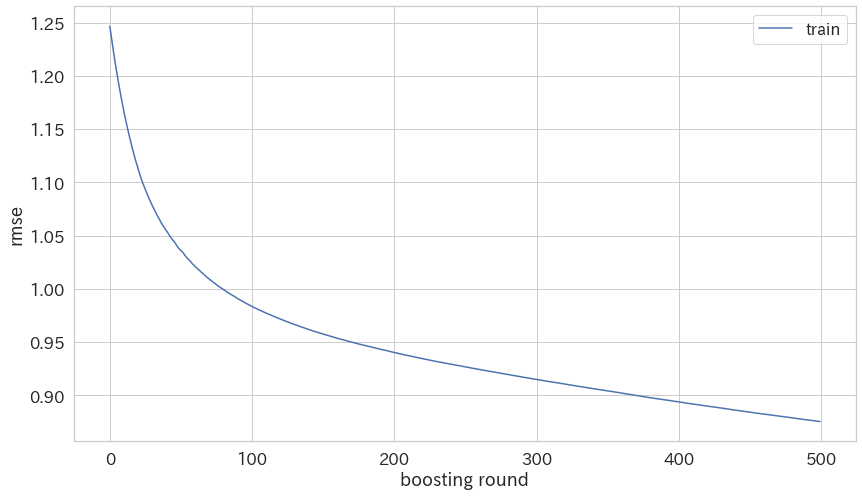

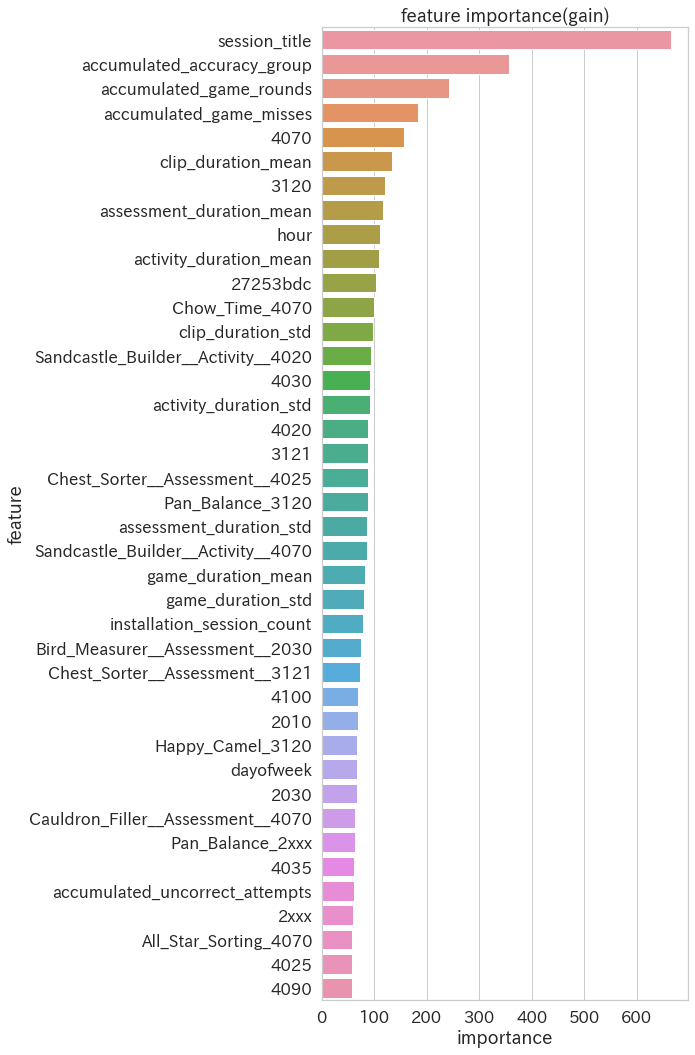

Wall time: 6.48 s


In [351]:
%%time
list_evaluation_results = []

train_data = lgb.Dataset(X_train, label=y_train)
    
evaluation_results = {}
lgbm = lgb.train(params={**lgb_params},
                 train_set=train_data,
                 num_boost_round=500,
                 valid_sets=[train_data, train_data],
                 evals_result=evaluation_results,
                 early_stopping_rounds=100,
                 verbose_eval=100)

list_evaluation_results.append([lgbm.best_iteration, \
                                np.round(evaluation_results["training"][lgb_params["metric"]][lgbm.best_iteration-1], 5)])
    
pred_train = lgbm.predict(X_train, num_iteration=lgbm.best_iteration)
pred_test = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

# Plot the rmse during training
plt.plot(evaluation_results["training"][lgb_params["metric"]], label="train")
plt.ylabel(lgb_params["metric"])
plt.xlabel("boosting round")
plt.legend()
plt.show()

# Plot feature importance
importances = pd.DataFrame({"feature": X_train.columns, "importance": lgbm.feature_importance()})
display_importances(importances)

In [352]:
del lgbm
gc.collect()

21766

In [353]:
%%time
from sklearn.model_selection import ParameterGrid
param_grid = {"a": np.arange(1.0, 1.2, 0.1), "b": np.arange(1.7, 1.9, 0.1), "c": np.arange(2.1, 2.4, 0.1)}

lgb_oof_pred = pred_train
pred_train_prob_summary["lgb_all"] = pred_train

max_qwk = 0
max_coef = None
for param in tqdm(list(ParameterGrid(param_grid)), total=12):
    a, b, c = param["a"], param["b"], param["c"]
    optR = OptimizedRounder()
    optR.fit(pred_train, y_train, "nelder-mead", [a, b, c])
    coefficients = optR.coefficients()
    opt_preds = optR.predict(pred_train, coefficients)
    score = qwk(opt_preds.get_values(), y_train)
    if max_qwk < score:
        max_qwk = score
        max_coef = coefficients
coefficients = max_coef
max_qwk, max_coef


Wall time: 1.43 s


(0.7086611752317561, array([1.0981182 , 1.69694909, 2.23680351]))

In [354]:
lgb_pred = pred_test
pred_test_prob_summary["lgb_all"] = pred_test

# qwk_opt_rg
lgb_pred[lgb_pred <= coefficients[0]] = 0
lgb_pred[np.where(np.logical_and(lgb_pred > coefficients[0], lgb_pred <= coefficients[1]))] = 1
lgb_pred[np.where(np.logical_and(lgb_pred > coefficients[1], lgb_pred <= coefficients[2]))] = 2
lgb_pred[lgb_pred > coefficients[2]] = 3

pred_class_summary["lgb_opt_all"] = lgb_pred.astype("int")

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.97188	training's qwk: 0.622601	valid_1's rmse: 1.01893	valid_1's qwk: 0.568109
[200]	training's rmse: 0.923694	training's qwk: 0.66457	valid_1's rmse: 1.00679	valid_1's qwk: 0.570419
Early stopping, best iteration is:
[110]	training's rmse: 0.965345	training's qwk: 0.625764	valid_1's rmse: 1.01637	valid_1's qwk: 0.57186
Partial score of seed 0 fold 0 is: 0.5718598793983586
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.978088	training's qwk: 0.616497	valid_1's rmse: 0.993667	valid_1's qwk: 0.585801
[200]	training's rmse: 0.930714	training's qwk: 0.654595	valid_1's rmse: 0.978546	valid_1's qwk: 0.592345
[300]	training's rmse: 0.89972	training's qwk: 0.685461	valid_1's rmse: 0.974694	valid_1's qwk: 0.602716
[400]	training's rmse: 0.875629	training's qwk: 0.706632	valid_1's rmse: 0.97364	valid_1's qwk: 0.606273
[500]	training's rmse: 0.854224	training's qwk: 0.724

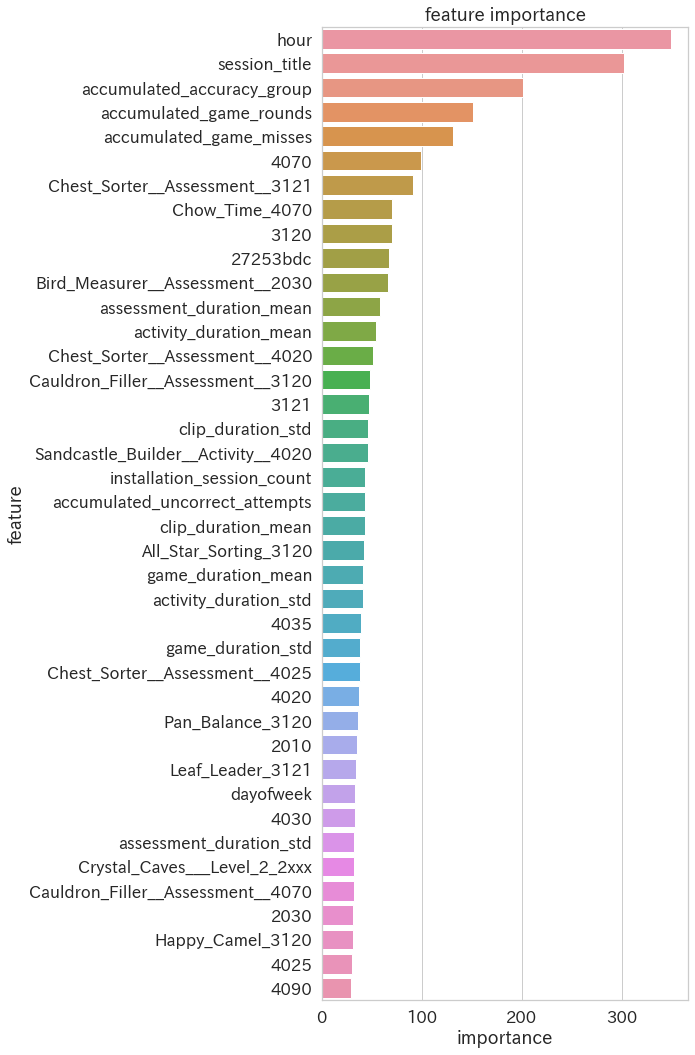

In [355]:
lgb_model = LGB_Model(train_df, test_df, features, categoricals=categoricals, n_splits=5, n_seeds=3, seeds=np.arange(0, 3, 1))

In [356]:
# 500 Seed averaging score is: 0.5867857611211679
# 900 Seed averaging score is: 0.5869490101104233
# 1000 Seed averaging score is: 0.5858150726618612
# 1500 Seed averaging score is: 0.5844762700780068
# 2000 Seed averaging score is: 0.5838973677847445

In [357]:
lgb_pred = lgb_model.y_pred
pred_test_prob_summary["lgb_cv"] = lgb_model.y_pred

# qwk_per_rg
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(lgb_pred, acum * 100)
print(bound)
    
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
lgb_pred = np.array(list(map(classify, lgb_pred)))
pred_class_summary["lgb_per_cv"] = lgb_pred.astype("int")

{0: 1.502797446479706, 1: 1.9641616877828207, 2: 2.1594258732680665}


In [358]:
# %%time
# from sklearn.model_selection import ParameterGrid
# param_grid = {"a": np.arange(1.0, 1.2, 0.1), "b": np.arange(1.7, 1.9, 0.1), "c": np.arange(2.1, 2.4, 0.1)}

# lgb_oof_pred = lgb_model.oof_pred
# pred_train_prob_summary["lgb_cv"] = lgb_oof_pred

# max_qwk = 0
# max_coef = None
# for param in tqdm(list(ParameterGrid(param_grid)), total=12):
#     a, b, c = param["a"], param["b"], param["c"]
#     optR = OptimizedRounder()
#     optR.fit(lgb_oof_pred, y_train, "nelder-mead", [a, b, c])
#     coefficients = optR.coefficients()
#     opt_preds = optR.predict(lgb_oof_pred, coefficients)
#     score = qwk(opt_preds.get_values(), y_train)
#     if max_qwk < score:
#         max_qwk = score
#         max_coef = coefficients
# coefficients = max_coef
# max_qwk, max_coef

In [359]:
lgb_pred = lgb_model.y_pred

# qwk_opt_rg
lgb_pred[lgb_pred <= coefficients[0]] = 0
lgb_pred[np.where(np.logical_and(lgb_pred > coefficients[0], lgb_pred <= coefficients[1]))] = 1
lgb_pred[np.where(np.logical_and(lgb_pred > coefficients[1], lgb_pred <= coefficients[2]))] = 2
lgb_pred[lgb_pred > coefficients[2]] = 3

pred_class_summary["lgb_opt_cv"] = lgb_pred.astype("int")

In [360]:
del lgb_model
gc.collect()

9883

In [361]:
pred_class_summary

,lgb_opt_all,lgb_per_cv,lgb_opt_cv,rf_opt_all
0,2,3,3,3
1,3,3,3,3
2,3,3,3,3
3,3,3,3,3
4,2,2,2,2
...,...,...,...,...
995,3,3,3,3
996,1,0,0,0
997,3,3,3,3
998,1,1,1,2


## Randam forest

In [321]:
from sklearn.ensemble import RandomForestRegressor

In [322]:
class RF_Model(Base_Model):
    
    def train_model(self, x_train, y_train):
        verbosity = 0 if self.verbose else 0
        clf = RandomForestRegressor(**self.params, n_jobs=4, verbose=verbosity)
        return clf.fit(x_train, y_train)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        return x_train, y_train
        
    def get_params(self):
        params = {'n_estimators': 100, 'max_depth': 23, 'max_features': 1.0}
        return params
    
    def get_feature_importance(self, model, importance_type="split"):
        return model.feature_importances_
        
    def display_feature_importance(self, feature_importance_df):
        feature_importance_df["importance"] = feature_importance_df.iloc[:, 1:].mean(axis=1)
        cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
        plt.figure(figsize=(10, 15))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title("feature importance")
        plt.tight_layout()
        plt.show()

In [323]:
def root_mean_squared_error(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred - y_true))) 
    
def hyperopt_random_forest(X: pd.DataFrame, y: pd.Series):
    # Group2Fold
    tra_index, val_index = KFold(n_splits=2, shuffle=True, random_state=1).split(unique_installation_ids)
 
    tra_groups, val_groups = unique_installation_ids[tra_index[0]], unique_installation_ids[val_index[0]]
    is_tra = installation_id.isin(tra_groups)
    is_val = installation_id.isin(val_groups)
    
    X_tra, y_tra = X[is_tra], y[is_tra]
    X_val, y_val = X[is_val], y[is_val]
   
    space = {
        "max_depth": hp.choice("max_depth", np.linspace(2, 20, 10, dtype=int)),
        "max_features": hp.quniform("max_features", 0.9, 1.0, 0.1),
    }
    
    def objective(hyperparams):
        
        clf = RandomForestRegressor(**hyperparams, n_estimators=100, verbose=0, n_jobs=4)
        clf.fit(X_tra, y_tra)
        pred = clf.predict(X_val)
        score = root_mean_squared_error(y_val, pred)

        return {"loss": score, "status": STATUS_OK}

    trials = Trials()
    best = hyperopt.fmin(fn=objective, space=space, trials=trials,
                         algo=tpe.suggest, max_evals=10, verbose=1,
                         rstate=np.random.RandomState(1))

    rf_params = space_eval(space, best) 
    print("rf_params = {0}".format({**rf_params}))
    
    return {**rf_params}

In [342]:
rf_params = {'n_estimators': 100, 'max_depth': 10, 'max_features': 0.9}

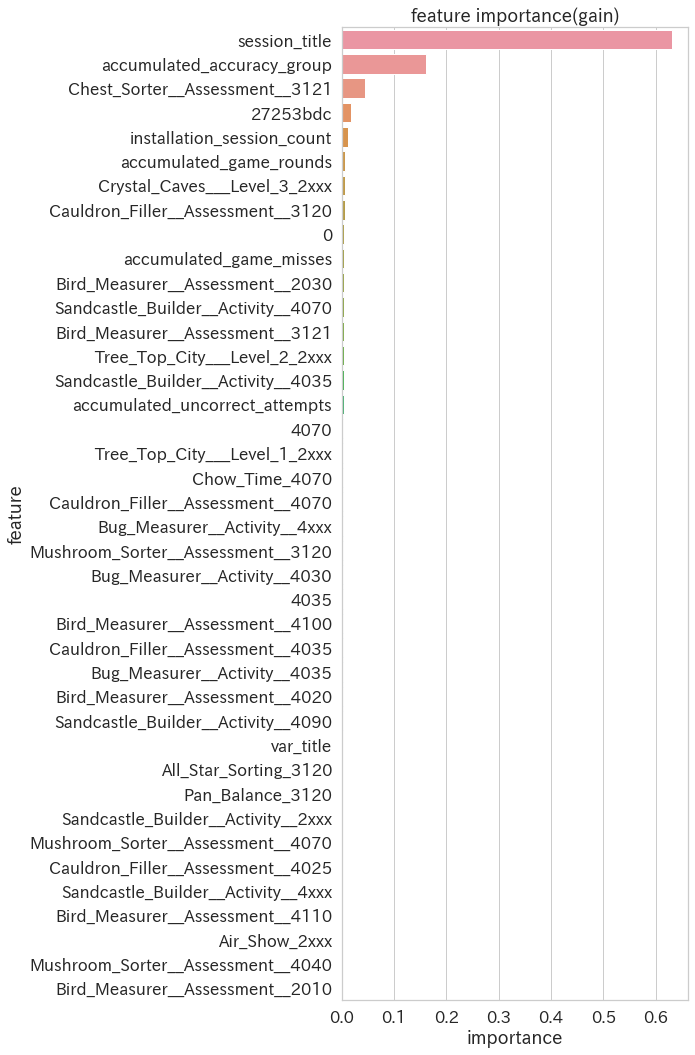

Wall time: 10.7 s


In [343]:
%%time
#rf_params = hyperopt_random_forest(X_train, y_train)

rfm = RandomForestRegressor(**rf_params, n_jobs=4, verbose=0)
rfm.fit(X_train, y_train)

pred_train = rfm.predict(X_train)
pred_test = rfm.predict(X_test)

# Plot feature importance
importances = pd.DataFrame({"feature": X_train.columns, "importance": rfm.feature_importances_})
display_importances(importances)

In [344]:
del rfm
gc.collect()

9836

In [345]:
%%time
from sklearn.model_selection import ParameterGrid
param_grid = {"a": np.arange(1.0, 1.2, 0.1), "b": np.arange(1.7, 1.9, 0.1), "c": np.arange(2.1, 2.4, 0.1)}

rf_oof_pred = pred_train
pred_train_prob_summary["rf_all"] = rf_oof_pred

max_qwk = 0
max_coef = None
for param in tqdm(list(ParameterGrid(param_grid)), total=12):
    a, b, c = param["a"], param["b"], param["c"]
    optR = OptimizedRounder()
    optR.fit(pred_train, y_train, "nelder-mead", [a, b, c])
    coefficients = optR.coefficients()
    opt_preds = optR.predict(pred_train, coefficients)
    score = qwk(opt_preds.get_values(), y_train)
    if max_qwk < score:
        max_qwk = score
        max_coef = coefficients
coefficients = max_coef
max_qwk, max_coef


Wall time: 1.46 s


(0.5770685440624843, array([1.13999685, 1.81212012, 2.12579698]))

In [346]:
rf_pred = pred_test
pred_test_prob_summary["rf_all"] = pred_test

# qwk_opt_rg
rf_pred[rf_pred <= coefficients[0]] = 0
rf_pred[np.where(np.logical_and(rf_pred > coefficients[0], rf_pred <= coefficients[1]))] = 1
rf_pred[np.where(np.logical_and(rf_pred > coefficients[1], rf_pred <= coefficients[2]))] = 2
rf_pred[rf_pred > coefficients[2]] = 3

pred_class_summary["rf_opt_all"] = rf_pred.astype("int")

Partial score of seed 3 fold 0 is: 0.557769236962772
Partial score of seed 3 fold 1 is: 0.5289077191406892
Partial score of seed 3 fold 2 is: 0.5223621119920878
Partial score of seed 3 fold 3 is: 0.541501039488565
Partial score of seed 3 fold 4 is: 0.5615093764472088
OOF score of seed 3 is: 0.5421592736005134
Partial score of seed 4 fold 0 is: 0.5437023528595677
Partial score of seed 4 fold 1 is: 0.5524305263520712
Partial score of seed 4 fold 2 is: 0.54605340907004
Partial score of seed 4 fold 3 is: 0.5351326035563122
Partial score of seed 4 fold 4 is: 0.5499675257132026
OOF score of seed 4 is: 0.5461125245997234
Partial score of seed 5 fold 0 is: 0.5376911502369215
Partial score of seed 5 fold 1 is: 0.5742863401734988
Partial score of seed 5 fold 2 is: 0.5196740684933867
Partial score of seed 5 fold 3 is: 0.5796389392935408
Partial score of seed 5 fold 4 is: 0.5156651984535536
OOF score of seed 5 is: 0.5454316723059756
Seed averaging score is: 0.5512823017135144


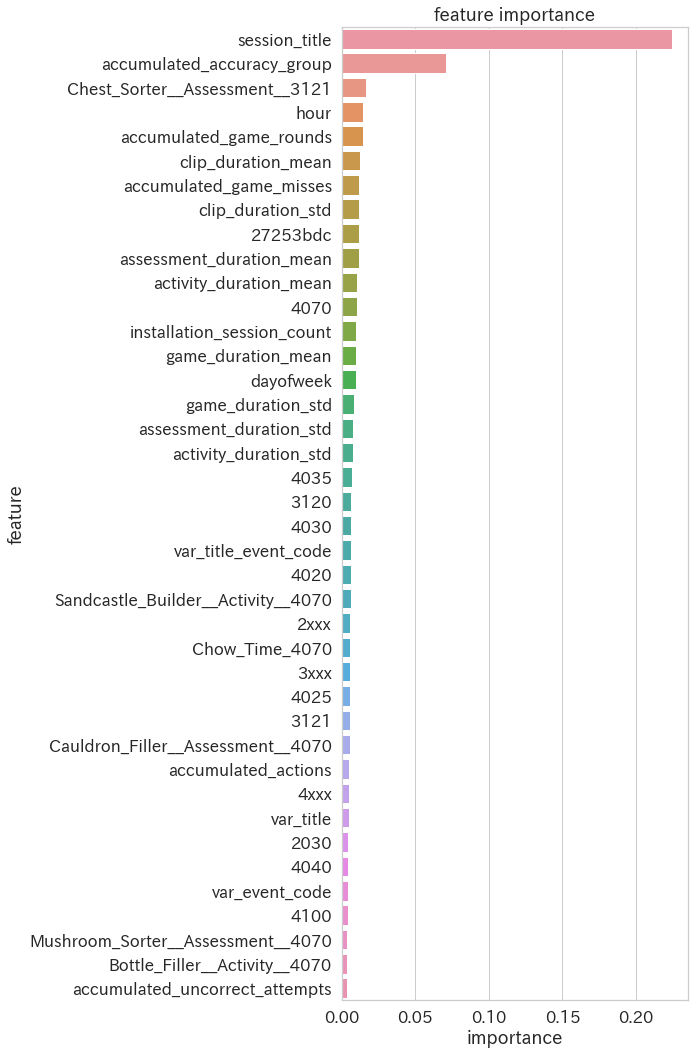

Wall time: 7min 41s


In [347]:
%%time
rf_model = RF_Model(train_df, test_df, features, categoricals=categoricals, n_splits=5, n_seeds=3, seeds=np.arange(3, 6, 1))

In [ ]:
# 50 Seed averaging score is: 0.5469902180465402
# 100 Seed averaging score is: 0.5551416420009105

In [202]:
rf_pred = rf_model.y_pred
pred_test_prob_summary["rf_cv"] = rf_model.y_pred

# qwk_per_rg
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(rf_pred, acum * 100)
print(bound)
    
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3

rf_pred = np.array(list(map(classify, rf_pred)))
pred_class_summary["rf_per_cv"] = rf_pred.astype("int")

{0: 1.4968113069644382, 1: 1.8504433414144716, 2: 2.1018003939591}


In [203]:
# %%time
# from sklearn.model_selection import ParameterGrid
# param_grid = {"a": np.arange(1.0, 1.2, 0.1), "b": np.arange(1.7, 1.9, 0.1), "c": np.arange(2.1, 2.4, 0.1)}

# rf_oof_pred = rf_model.oof_pred
# pred_train_prob_summary["rf_cv"] = rf_oof_pred

# max_qwk = 0
# max_coef = None
# for param in tqdm(list(ParameterGrid(param_grid)), total=12):
#     a, b, c = param["a"], param["b"], param["c"]
#     optR = OptimizedRounder()
#     optR.fit(rf_oof_pred, y_train, "nelder-mead", [a, b, c])
#     coefficients = optR.coefficients()
#     opt_preds = optR.predict(rf_oof_pred, coefficients)
#     score = qwk(opt_preds.get_values(), y_train)
#     if max_qwk < score:
#         max_qwk = score
#         max_coef = coefficients
# coefficients = max_coef
# max_qwk, max_coef


Wall time: 1.58 s


(0.5649058954856121, array([1.20340568, 1.5557062 , 2.10276054]))

In [204]:
rf_pred = rf_model.y_pred

# qwk_opt_rg
rf_pred[rf_pred <= coefficients[0]] = 0
rf_pred[np.where(np.logical_and(rf_pred > coefficients[0], rf_pred <= coefficients[1]))] = 1
rf_pred[np.where(np.logical_and(rf_pred > coefficients[1], rf_pred <= coefficients[2]))] = 2
rf_pred[rf_pred > coefficients[2]] = 3

pred_class_summary["rf_opt_cv"] = rf_pred.astype("int")

In [205]:
del rf_model
gc.collect()

9750

## NN

In [422]:
# https://www.kaggle.com/higepon/starter-keras-simple-nn-kfold-cv
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

import tensorflow as tf
from tensorflow.keras.metrics import Metric
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, Embedding, LayerNormalization, concatenate, BatchNormalization, Flatten
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [423]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [424]:
class NN_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, n_seeds=3, seeds=np.arange(0, 3, 1), verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ["{}_{}".format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, n_seeds, seeds, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 0 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set["X"].shape[1],)),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu")
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss="mse")
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint("nn_model.w8", save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set["X"], 
                  train_set["y"], 
                  validation_data=(val_set["X"], val_set["y"]),
                  epochs=100,
                  verbose=verbosity,
                  callbacks=[save_best, early_stop])
        model.load_weights("nn_model.w8")
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {"X": x_train, "y": y_train}
        val_set = {"X": x_val, "y": y_val}
        return train_set, val_set
        
    def get_params(self):
        return None
    
    def get_feature_importance(self, importance_type=""):
        return None
    
    def display_feature_importance(self, feature_importance_df):
        return None

In [425]:
def build_model(X):
       
    model = Sequential([
        Input(shape=(X.shape[1],)),
        Dense(256, activation="relu"),
        LayerNormalization(),
        Dropout(0.3),
        Dense(128, activation="relu"),
        LayerNormalization(),
        Dropout(0.3),
        Dense(64, activation="relu"),
        LayerNormalization(),
        Dropout(0.3),
        Dense(32, activation="relu"),
        LayerNormalization(),
        Dropout(0.3),
        Dense(1, activation="relu")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss="mse")
    
    print(model.summary())
    return model

In [426]:
categoricals = ["session_title"]

if len(categoricals) > 0:
    for cat in categoricals:
        enc = OneHotEncoder()
        train_cats = enc.fit_transform(X_train[[cat]])
        test_cats = enc.transform(X_test[[cat]])
        cat_cols = ["{}_{}".format(cat, str(col)) for col in enc.active_features_]
        features += cat_cols
        train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
        test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
        X_train = pd.concat([X_train, train_cats], axis=1)
        X_test = pd.concat([X_test, test_cats], axis=1)
scalar = MinMaxScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [427]:
%%time
oof = np.zeros(len(train_df.index))
nn_predictions = np.zeros(len(test_df.index))
n_batch_size = 2 ** 5
n_epochs = 50
n_patience = 10
decay_per_epoch = (0.0004-0.0001) / n_epochs

# 学習率
def step_decay(epoch):
    lr = 0.0004
    lr -= decay_per_epoch * epoch
    return lr
lr_decay = LearningRateScheduler(step_decay)

nnm = build_model(X_train)
callbacks = [lr_decay]
nnm.fit(X_train, y_train.astype("float64"), epochs=n_epochs, callbacks=callbacks, verbose=2)

pred_train = nnm.predict(X_train)
pred_train =  pred_train.reshape(pred_train.shape[0])

pred_test = nnm.predict(X_test)
pred_test =  pred_test.reshape(pred_test.shape[0])

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_555 (Dense)            (None, 256)               96512     
_________________________________________________________________
layer_normalization_444 (Lay (None, 256)               512       
_________________________________________________________________
dropout_444 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_556 (Dense)            (None, 128)               32896     
_________________________________________________________________
layer_normalization_445 (Lay (None, 128)               256       
_________________________________________________________________
dropout_445 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_557 (Dense)            (None, 64)             

In [428]:
del nnm
gc.collect()

171091

In [429]:
%%time
from sklearn.model_selection import ParameterGrid
param_grid = {"a": np.arange(1.0, 1.2, 0.1), "b": np.arange(1.7, 1.9, 0.1), "c": np.arange(2.1, 2.4, 0.1)}

nn_oof_pred = pred_train
pred_train_prob_summary["nn_all"] = nn_oof_pred

max_qwk = 0
max_coef = None
for param in tqdm(list(ParameterGrid(param_grid)), total=12):
    a, b, c = param["a"], param["b"], param["c"]
    optR = OptimizedRounder()
    optR.fit(pred_train, y_train, "nelder-mead", [a, b, c])
    coefficients = optR.coefficients()
    opt_preds = optR.predict(pred_train, coefficients)
    score = qwk(opt_preds.get_values(), y_train)
    if max_qwk < score:
        max_qwk = score
        max_coef = coefficients
coefficients = max_coef
max_qwk, max_coef


Wall time: 1.68 s


(0.7910801947188225, array([0.91930134, 1.50421467, 2.32831078]))

In [430]:
nn_pred = pred_test
pred_test_prob_summary["nn_all"] = pred_test

# qwk_opt_rg
nn_pred[nn_pred <= coefficients[0]] = 0
nn_pred[np.where(np.logical_and(nn_pred > coefficients[0], nn_pred <= coefficients[1]))] = 1
nn_pred[np.where(np.logical_and(nn_pred > coefficients[1], nn_pred <= coefficients[2]))] = 2
nn_pred[nn_pred > coefficients[2]] = 3

pred_class_summary["nn_opt_all"] = nn_pred.astype("int")

In [431]:
nn_model = NN_Model(train_df, test_df, features, categoricals=categoricals, n_splits=5, n_seeds=3, seeds=np.arange(6, 9, 1))

(17690, 381)
Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_560 (Dense)            (None, 256)               97792     
_________________________________________________________________
layer_normalization_448 (Lay (None, 256)               512       
_________________________________________________________________
dropout_448 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_561 (Dense)            (None, 128)               32896     
_________________________________________________________________
layer_normalization_449 (Lay (None, 128)               256       
_________________________________________________________________
dropout_449 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_562 (Dense)            (None, 64)

Epoch 00014: val_loss improved from 1.08674 to 1.08067, saving model to nn_model.w8

Epoch 00015: val_loss did not improve from 1.08067

Epoch 00016: val_loss did not improve from 1.08067

Epoch 00017: val_loss did not improve from 1.08067

Epoch 00018: val_loss did not improve from 1.08067

Epoch 00019: val_loss did not improve from 1.08067

Epoch 00020: val_loss did not improve from 1.08067

Epoch 00021: val_loss did not improve from 1.08067

Epoch 00022: val_loss did not improve from 1.08067

Epoch 00023: val_loss did not improve from 1.08067

Epoch 00024: val_loss did not improve from 1.08067

Epoch 00025: val_loss did not improve from 1.08067

Epoch 00026: val_loss did not improve from 1.08067

Epoch 00027: val_loss did not improve from 1.08067

Epoch 00028: val_loss did not improve from 1.08067

Epoch 00029: val_loss did not improve from 1.08067

Epoch 00030: val_loss did not improve from 1.08067

Epoch 00031: val_loss did not improve from 1.08067

Epoch 00032: val_loss did not i


Epoch 00005: val_loss did not improve from 1.13306

Epoch 00006: val_loss did not improve from 1.13306

Epoch 00007: val_loss improved from 1.13306 to 1.12694, saving model to nn_model.w8

Epoch 00008: val_loss improved from 1.12694 to 1.11214, saving model to nn_model.w8

Epoch 00009: val_loss improved from 1.11214 to 1.08554, saving model to nn_model.w8

Epoch 00010: val_loss did not improve from 1.08554

Epoch 00011: val_loss did not improve from 1.08554

Epoch 00012: val_loss improved from 1.08554 to 1.06096, saving model to nn_model.w8

Epoch 00013: val_loss did not improve from 1.06096

Epoch 00014: val_loss improved from 1.06096 to 1.04829, saving model to nn_model.w8

Epoch 00015: val_loss improved from 1.04829 to 1.03725, saving model to nn_model.w8

Epoch 00016: val_loss did not improve from 1.03725

Epoch 00017: val_loss did not improve from 1.03725

Epoch 00018: val_loss did not improve from 1.03725

Epoch 00019: val_loss did not improve from 1.03725

Epoch 00020: val_loss

dense_608 (Dense)            (None, 32)                2080      
_________________________________________________________________
layer_normalization_487 (Lay (None, 32)                64        
_________________________________________________________________
dropout_487 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_609 (Dense)            (None, 1)                 33        
Total params: 142,017
Trainable params: 142,017
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 1.12355, saving model to nn_model.w8

Epoch 00002: val_loss improved from 1.12355 to 1.12030, saving model to nn_model.w8

Epoch 00003: val_loss improved from 1.12030 to 1.06304, saving model to nn_model.w8

Epoch 00004: val_loss improved from 1.06304 to 1.05592, saving model to nn_model.w8

Epoch 00005: val_loss improved from 1.05592 to 1.04249, sa

dropout_500 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_626 (Dense)            (None, 128)               32896     
_________________________________________________________________
layer_normalization_501 (Lay (None, 128)               256       
_________________________________________________________________
dropout_501 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_627 (Dense)            (None, 64)                8256      
_________________________________________________________________
layer_normalization_502 (Lay (None, 64)                128       
_________________________________________________________________
dropout_502 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_628 (Dense)            (None, 32)                2080      
__________

In [ ]:
# 50, 128 Seed averaging score is: 0.5712944469265342
# 50, 200 Seed averaging score is: 0.5790046586564301
# 50, 256 Seed averaging score is: 0.5816427541003732
# 25, 256 Seed averaging score is: 0.5751721582019647

In [220]:
nn_pred = nn_model.y_pred
pred_test_prob_summary["nn_cv"] = nn_model.y_pred

# qwk_per_rg
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(nn_pred, acum * 100)
print(bound)
    
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3

nn_pred = np.array(list(map(classify, nn_pred)))
pred_class_summary["nn_per_cv"] = nn_pred.astype("int")

{0: 1.4711431922842064, 1: 1.9652525171769502, 2: 2.1791432301203413}


In [221]:
# %%time
# from sklearn.model_selection import ParameterGrid
# param_grid = {"a": np.arange(1.0, 1.2, 0.1), "b": np.arange(1.7, 1.9, 0.1), "c": np.arange(2.1, 2.4, 0.1)}

# nn_oof_pred = nn_model.oof_pred
# pred_train_prob_summary["nn_cv"] = nn_oof_pred

# max_qwk = 0
# max_coef = None
# for param in tqdm(list(ParameterGrid(param_grid)), total=12):
#     a, b, c = param["a"], param["b"], param["c"]
#     optR = OptimizedRounder()
#     optR.fit(nn_oof_pred, y_train, "nelder-mead", [a, b, c])
#     coefficients = optR.coefficients()
#     opt_preds = optR.predict(nn_oof_pred, coefficients)
#     score = qwk(opt_preds.get_values(), y_train)
#     if max_qwk < score:
#         max_qwk = score
#         max_coef = coefficients
# coefficients = max_coef
# max_qwk, max_coef


Wall time: 1.48 s


(0.5839873191688827, array([0.94591976, 1.61179456, 2.26961993]))

In [222]:
nn_pred = nn_model.y_pred

# qwk_opt_rg
nn_pred[nn_pred <= coefficients[0]] = 0
nn_pred[np.where(np.logical_and(nn_pred > coefficients[0], nn_pred <= coefficients[1]))] = 1
nn_pred[np.where(np.logical_and(nn_pred > coefficients[1], nn_pred <= coefficients[2]))] = 2
nn_pred[nn_pred > coefficients[2]] = 3

pred_class_summary["nn_opt_cv"] = nn_pred.astype("int")
pred_class_summary

,lgb_opt_all,lgb_per_cv,lgb_opt_cv,rf_opt_all,rf_per_cv,rf_opt_cv,nn_opt_all,nn_per_cv,nn_opt_cv
0,2,3,3,3,3,3,2,3,3
1,3,3,3,3,3,3,3,3,3
2,3,3,3,3,3,3,3,3,3
3,3,3,3,3,3,3,3,3,3
4,3,2,2,2,3,3,3,2,2
...,...,...,...,...,...,...,...,...,...
995,3,3,3,3,3,3,3,3,3
996,1,0,0,0,0,0,0,0,0
997,3,3,3,3,3,3,3,3,3
998,1,1,1,1,1,2,0,1,1


In [223]:
del nn_model
gc.collect()

114792

# submission

In [224]:
pred_test_prob_summary

,lgb_all,lgb_cv,rf_all,rf_cv,nn_all,nn_cv
0,2.171703,2.257017,2.508326,2.346505,2.302445,2.336529
1,2.971333,2.800015,2.708794,2.863292,2.758777,2.657650
2,2.751382,2.504044,2.507607,2.639469,2.379507,2.333611
3,2.357011,2.335669,2.461108,2.625707,2.484647,2.372694
4,2.270060,2.016201,2.123623,2.375488,2.604543,2.066536
...,...,...,...,...,...,...
995,2.726633,2.697213,2.676580,2.680464,2.666026,2.645764
996,1.201349,0.992224,0.899507,0.669217,0.541987,0.880499
997,2.329524,2.315981,2.466145,2.430800,2.565837,2.441716
998,1.640208,1.636039,1.707876,1.663916,0.734437,1.520271


In [225]:
weights = {"lgb": 0.70, "rf": 0.15, "nn": 0.15}

In [226]:
pred_test_prob_summary["average"] = pred_test_prob_summary.mean(axis=1)
#pred_test_prob_summary["average"] = (pred_test_prob_summary["lgb_cv"] * weights['lgb']) + (pred_test_prob_summary["rf_cv"] * weights['rf']) + (pred_test_prob_summary["nn_cv"] * weights['nn'])
pred_test_prob_summary

,lgb_all,lgb_cv,rf_all,rf_cv,nn_all,nn_cv,average
0,2.171703,2.257017,2.508326,2.346505,2.302445,2.336529,2.320421
1,2.971333,2.800015,2.708794,2.863292,2.758777,2.657650,2.793310
2,2.751382,2.504044,2.507607,2.639469,2.379507,2.333611,2.519270
3,2.357011,2.335669,2.461108,2.625707,2.484647,2.372694,2.439473
4,2.270060,2.016201,2.123623,2.375488,2.604543,2.066536,2.242742
...,...,...,...,...,...,...,...
995,2.726633,2.697213,2.676580,2.680464,2.666026,2.645764,2.682113
996,1.201349,0.992224,0.899507,0.669217,0.541987,0.880499,0.864130
997,2.329524,2.315981,2.466145,2.430800,2.565837,2.441716,2.425001
998,1.640208,1.636039,1.707876,1.663916,0.734437,1.520271,1.483791


In [227]:
pred_train_prob_summary["average"] = pred_train_prob_summary.mean(axis=1)
#pred_train_prob_summary["average"] = (pred_train_prob_summary["lgb_cv"] * weights['lgb']) + (pred_train_prob_summary["rf_cv"] * weights['rf']) + (pred_train_prob_summary["nn_cv"] * weights['nn'])
pred_train_prob_summary

,lgb_all,lgb_cv,rf_all,rf_cv,nn_all,nn_cv,average
0,2.307947,2.153002,2.280973,2.140018,2.515630,2.176394,2.262327
1,1.292462,1.692662,1.172316,1.637873,1.019262,1.564623,1.396533
2,2.315230,2.258571,2.445781,2.382383,2.694366,2.435769,2.422017
3,2.324946,2.249676,2.405172,2.582918,2.663650,2.448273,2.445773
4,1.396749,1.050835,1.550245,0.960000,1.622936,0.847810,1.238096
...,...,...,...,...,...,...,...
17685,2.056189,1.737973,1.920625,1.673369,2.112088,1.538507,1.839792
17686,2.463634,2.334492,2.438035,2.357210,2.644447,2.361430,2.433208
17687,1.737008,2.043062,1.733838,1.889724,1.907231,1.926995,1.872976
17688,1.096285,1.936610,1.077634,1.553747,0.928195,2.230547,1.470503


## optimize

In [228]:
%%time
from sklearn.model_selection import ParameterGrid
param_grid = {"a": np.arange(1.0, 1.2, 0.1), "b": np.arange(1.7, 1.9, 0.1), "c": np.arange(2.1, 2.4, 0.1)}

max_qwk = 0
max_coef = None
for param in tqdm(list(ParameterGrid(param_grid)), total=12):
    a, b, c = param["a"], param["b"], param["c"]
    optR = OptimizedRounder()
    optR.fit(pred_train_prob_summary["average"], y_train, "nelder-mead", [a, b, c])
    coefficients = optR.coefficients()
    opt_preds = optR.predict(pred_train_prob_summary["average"], coefficients)
    score = qwk(opt_preds.get_values(), y_train)
    if max_qwk < score:
        max_qwk = score
        max_coef = coefficients
coefficients = max_coef
max_qwk, max_coef


Wall time: 2.04 s


(0.6984359853530886, array([1.08271359, 1.68104064, 2.16847313]))

In [229]:
optimize_pred_test = pred_test_prob_summary["average"].copy().values

# qwk_opt_rg
optimize_pred_test[optimize_pred_test <= coefficients[0]] = 0
optimize_pred_test[np.where(np.logical_and(optimize_pred_test > coefficients[0], optimize_pred_test <= coefficients[1]))] = 1
optimize_pred_test[np.where(np.logical_and(optimize_pred_test > coefficients[1], optimize_pred_test <= coefficients[2]))] = 2
optimize_pred_test[optimize_pred_test > coefficients[2]] = 3

optimize_pred_test = optimize_pred_test.astype("int")

## percentage

In [230]:
per_pred_test = pred_test_prob_summary["average"].copy().values

# qwk_per_rg
dist = Counter(train_df["accuracy_group"])
for k in dist:
    dist[k] /= len(train_df)
    
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(per_pred_test, acum * 100)
print(bound)
    
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3

per_pred_test = np.array(list(map(classify, per_pred_test)))

{0: 1.5096810832436862, 1: 1.9403662798106915, 2: 2.1652143569062243}


## discussion

In [231]:
pred_class_summary

,lgb_opt_all,lgb_per_cv,lgb_opt_cv,rf_opt_all,rf_per_cv,rf_opt_cv,nn_opt_all,nn_per_cv,nn_opt_cv
0,2,3,3,3,3,3,2,3,3
1,3,3,3,3,3,3,3,3,3
2,3,3,3,3,3,3,3,3,3
3,3,3,3,3,3,3,3,3,3
4,3,2,2,2,3,3,3,2,2
...,...,...,...,...,...,...,...,...,...
995,3,3,3,3,3,3,3,3,3
996,1,0,0,0,0,0,0,0,0
997,3,3,3,3,3,3,3,3,3
998,1,1,1,1,1,2,0,1,1


In [232]:
pred_class_summary["0"] = (pred_class_summary.iloc[:, :9] == 0).sum(axis=1)
pred_class_summary["1"] = (pred_class_summary.iloc[:, :9] == 1).sum(axis=1)
pred_class_summary["2"] = (pred_class_summary.iloc[:, :9] == 2).sum(axis=1)
pred_class_summary["3"] = (pred_class_summary.iloc[:, :9] == 3).sum(axis=1)

In [233]:
discuss_pred_test = pred_class_summary[["0", "1", "2", "3"]].idxmax(axis=1).astype("int")

## total

In [234]:
summary = pd.DataFrame()
summary["optimize"] = optimize_pred_test.astype("int")
summary["percentage"] = per_pred_test.astype("int")
summary["discussion"] = pred_class_summary[["0", "1", "2", "3"]].idxmax(axis=1).astype("int")
summary["0"] = (summary.iloc[:, :3] == 0).sum(axis=1)
summary["1"] = (summary.iloc[:, :3] == 1).sum(axis=1)
summary["2"] = (summary.iloc[:, :3] == 2).sum(axis=1)
summary["3"] = (summary.iloc[:, :3] == 3).sum(axis=1)
summary

,optimize,percentage,discussion,0,1,2,3
0,3,3,3,0,0,0,3
1,3,3,3,0,0,0,3
2,3,3,3,0,0,0,3
3,3,3,3,0,0,0,3
4,3,3,2,0,0,1,2
...,...,...,...,...,...,...,...
995,3,3,3,0,0,0,3
996,0,0,0,3,0,0,0
997,3,3,3,0,0,0,3
998,1,0,1,1,2,0,0


In [235]:
submission = pd.read_csv(data_dir + "sample_submission.csv")
submission["accuracy_group"] = summary[["0", "1", "2", "3"]].idxmax(axis=1).astype("int")
#submission["accuracy_group"] = pred_class_summary[["0", "1", "2", "3"]].idxmax(axis=1).astype("int")
#submission["accuracy_group"] = per_pred_test.astype("int")
#submission["accuracy_group"] = optimize_pred_test.astype("int")
submission

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
...,...,...
995,fee254cf,3
996,ff57e602,0
997,ffc73fb2,3
998,ffe00ca8,1


In [236]:
submission['accuracy_group'].value_counts(normalize=True)

3    0.499
2    0.198
0    0.186
1    0.117
Name: accuracy_group, dtype: float64

In [61]:
# 3    0.431
# 2    0.253
# 0    0.159
# 1    0.157
# Name: accuracy_group, dtype: float64

In [62]:
train_df['accuracy_group'].value_counts(normalize=True)

3    0.500000
0    0.239062
1    0.136292
2    0.124647
Name: accuracy_group, dtype: float64

In [ ]:
submission.to_csv("submission.csv", index=False)